In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

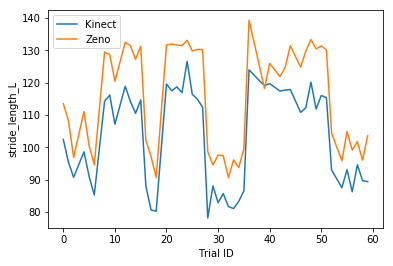

In [3]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

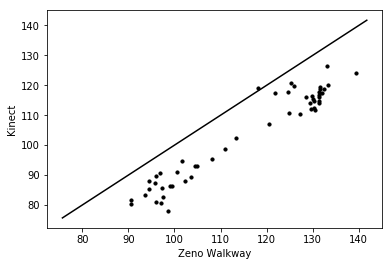

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_L'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

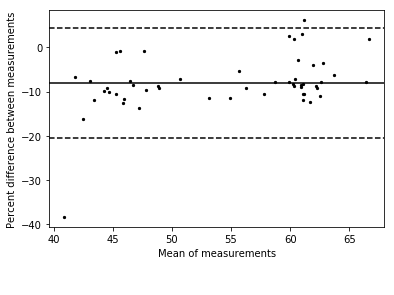

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.931670,0.970416,0.963520,0.976374,0.936958,0.895340,0.965294,0.936008,0.825994,0.913305
Spearman,0.851618,0.894988,0.876291,0.919468,0.725904,0.607228,0.855289,0.817724,0.765560,0.790745
Abs rel error,0.081475,0.125745,0.106262,0.100097,0.200833,0.192597,0.120069,0.111525,2.515967,2.912711
Bias,-0.080049,-0.134677,-0.112647,-0.105910,-0.226590,-0.217860,0.098319,0.086692,-0.418326,1.310151
Range,0.248705,0.128919,0.157515,0.133294,0.342470,0.409738,0.351562,0.383595,25.668781,23.954424


In [7]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.976537,0.977750,0.929955,0.959506,0.905925
Spearman,0.899940,0.902501,0.656570,0.840434,0.813114
Abs rel error,0.101288,0.103093,0.196871,0.112167,1.440678
Bias,-0.107246,-0.109174,-0.221637,0.093236,-16.838138
Range,0.136165,0.125125,0.339406,0.336557,489.275225


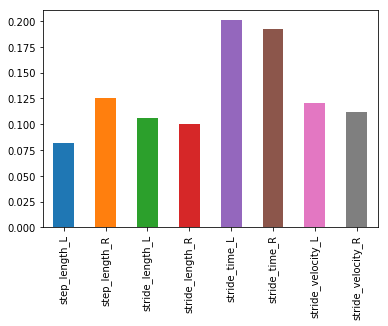

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.924687,0.938289
Spearman,0.814932,0.806031
Abs rel error,0.604921,0.688535
Bias,-0.147859,0.187679
Range,5.353807,5.001994


In [10]:
df_grouped.stride_length * 100

Pearson          97.775013
Spearman         90.250149
Abs rel error    10.309293
Bias            -10.917446
Range            12.512525
Name: stride_length, dtype: float64

In [11]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [12]:
max_idx = df_rel_error.stride_length_L.idxmax()